# RNA - Trabajo Práctico 1 - E1
Jonathan Teran <jteran@dc.uba.ar>

En este notebook exploraremos tecnicas y modelos para una red neuronal que resuelva el ejercicio 1 del TP1.

## Diagnóstico de cáncer de mamas

Los datos los recibimos en el archivo `tp1_ej1_training.csv`, siendo la primera columna el diagnóstico del caso particular, y las que siguen los datos de entrada del modelo. En un principio no nos interesan que representa cada dato, así que arrancaremos por normalizarlos cargarlos del csv y normalizarlos.

In [1]:
# importamos librería necesarias
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm

Para leer los datos utilizaremos `pandas`, y separaremos los datos de entrada en `X`, y los de salida en `Z`, interpretando el diagnóstico como 1 si es benigno, y -1 si es maligno

In [2]:
# cargar datos
DATA_FILE = 'tp1_ej1_training.csv'
df = pd.read_csv(DATA_FILE, header=None)
# ponemos todos los datos de entrada en X
X = df.loc[:,1:].to_numpy()
# los normalizamos
X = (X - X.mean(0)) / X.std(0, ddof=1)
# y los de salida en Z
Z = np.array([1 if d == 'B' else -1 for d in df.loc[:, 0]])

A continuación definiremos variables que definirán nuestro modelo, como la cantidad de nodos por capa, o la distribución de los datos en datos de testeo, validación y entrenamiento.

Utilizaremos los datos de entrenamiento para entrenar la red, los de validación para verificar si el modelo es apropiado o deberíamos cambiarlo, y cuando nos hayamos decidido por un modelo particular, usaremos los de testeo para comprobar que tanto puede generalizar a otras instancias.

In [37]:
P = len(X)
N = 10 # unidades de entrada
M = 1 # unidades de salida
S = [N, 20, 8, M] # distribución de nodos por capa
L = len(S) # cantidad de capas
LR = 1e-3 # learning rate

# cantidades reservadas para: 
C_T = int(P * .05)  # testeo
C_V = int(P * .15)  # validacion
C_E = P - C_T - C_V # entrenamiento

B = 16 # tamaños para los mini-lotes

Finalmente, definiremos las funciones del modelo.

In [4]:
def bias_add(a):
    b = len(a)
    return np.concatenate((a, -np.ones((b,1))), axis=1)

def bias_del(a):
    return a[:,:-1]

In [5]:
def activacion(X, W):
    b = len(X)
    # nodos por capa + nodo extra para el bias
    Y = [ np.empty((b, S[i]+1)) for i in range(L)]
    Y[L-1] = np.empty((b, M))
    # Y sin bias
    Ysb = X
    for i in range (1, L):
        Y[i-1][:,:] = bias_add(Ysb)
        Ysb = np.tanh(np.dot(Y[i-1], W[i-1]))
    Y[L-1][:,:] = Ysb
    
    return Y

In [30]:
def correccion(W, Y, Z):
    b = len(Z)
    dW = [ np.empty_like(w) for w in W ]
    D  = [ np.empty_like(y) for y in Y]
    E  = Z.reshape((b, 1)) - Y[L-1]
    dY = 1 - np.square(Y[L-1])
    D[L-1] = np.multiply(E, dY)
    
    for k in range(L-1, 0, -1):
        dE = [ np.outer(Y[k-1][i], D[k][i]) for i in range(b) ]
        dW[k-1] = LR * np.mean(dE, axis=0)
        E = np.dot(D[k], W[k-1].T)
        dY = 1 - np.square(Y[k-1])
        D[k-1] = bias_del(np.multiply(E, dY))
    
    return dW

In [7]:
def adaptacion(W, dW):
    return [ W[i] + dW[i] for i in range(L-1) ]

In [34]:
def entrenamiento(W, X, Z):
    t_max = 2000
    t = 0
    errores = []
    error_estim = []
    while t < t_max:
        e = 0
        indices = np.random.permutation(len(X))
        for batch in range(0, len(indices), B):
            h  = indices[batch : batch+B]
            Xh = X[h]
            Zh = Z[h]
            Yh = activacion(Xh, W)
            e += np.mean(np.square(np.subtract(Zh, np.sign(Yh[L-1].T))))
            dW = correccion(W, Yh, Zh)
            W  = adaptacion(W, dW)
        errores.append(e)
        t += 1
        if t % 100 == 0:
            print(t, e)
    plt.plot(errores, 'r')
    plt.show()
    
    return W

In [9]:
def validacion(W, X, Z):
    # calculamos las activaciones para los datos de validacion
    Y = activacion(X, W)
    # contamos cuantos de los resultados del modelo concuerdan con el valor esperado
    V = np.subtract(Z, np.sign(Y[L-1]).T)
    return np.count_nonzero(V) / C_V

In [10]:
def init_pesos():
    W = [ np.random.randn(S[i]+1, S[i+1]) * np.sqrt(2/S[i]) for i in range(L-1) ]
    return W

100 30.333333333333332
200 24.77777777777778
300 19.63888888888889
400 15.88888888888889
500 13.694444444444445
600 12.63888888888889
700 10.25
800 8.75
900 8.63888888888889
1000 8.13888888888889
1100 6.888888888888889
1200 6.5
1300 5.694444444444445
1400 5.388888888888889
1500 4.0
1600 3.75
1700 2.5
1800 2.888888888888889
1900 2.0
2000 2.0


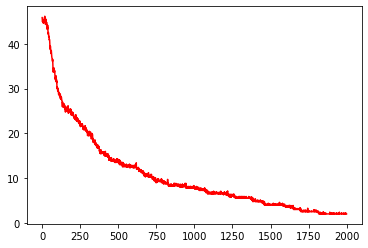

0.14754098360655737


In [38]:
# busqueda de modelo
# usaremos los datos de entrenamiento y de validación para entrenar la
# red y evaluar si los resultados obtenidos son buenos o no.
W = init_pesos()
h_ent = range(0, C_E)
W = entrenamiento(W, X[h_ent], Z[h_ent])
h_val = range(C_E+1, P-C_T+1)
print(validacion(W, X[h_val], Z[h_val]))

100 39.333333333333336
200 30.916666666666668
300 25.833333333333332
400 19.666666666666668
500 18.666666666666668
600 16.666666666666668
700 14.5
800 14.166666666666666
900 12.0
1000 10.916666666666666
1100 7.75
1200 8.0
1300 7.916666666666667
1400 7.916666666666667
1500 6.5
1600 6.166666666666667
1700 6.166666666666667
1800 5.0
1900 5.166666666666667
2000 4.25


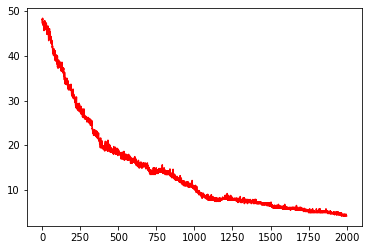

0.01639344262295082


In [42]:
# testeo
# una vez que encontramos un buen modelo, incluimos los datos de validacion
# para entrenar la red y testeamos los resultados con los datos de test
W = init_pesos()
h_ent = range(0, P-C_T)
W = entrenamiento(W, X[h_ent], Z[h_ent])
h_test = range(P-C_T, P)
print(validacion(W, X[h_test], Z[h_test]))